In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import scipy.sparse as sparse
import scipy.linalg as linalg
from scipy.sparse.linalg import LinearOperator
import numpy as np
import collections
import copy

import amfe
from amfe.utils.utils import OrderedSet
from amfe.cyclic.cyclic import SelectionOperator, apply_cyclic_symmetry, get_all_dofs, rotate_u, set_cyclic_modes_to_component
from amfe.cyclic.cyclic import create_voigt_rotation_matrix, assemble_cyclic_modes, cyclic_symmetry_modal_analysis, Cyclic_Symmetry_Modal_Analysis
from amfe.cyclic.cyclic import create_rotated_component, create_voigt_rotation_matrix, Cyclic_Component
from amfe.utils.utils import get_dofs
from amfe.linalg.arnoldi import arnoldi_iteration, inverse_arnoldi_iteration, general_inverse_arnoldi_iteration, generalized_arnoldi_iteration
from amfe.linalg.arnoldi import lanczos, is_eigvec, nullspace, LinearSys, power_iteration, ProjLinearSys, compute_modes, eigvec_error_vector, is_nullspace
from amfe.linalg.arnoldi import is_moore_pensore_inverse, ProjPrecondLinearSys
from amfe.units import convert
import pandas as pd

msh_file = r'meshes\one_forth_disk_quad.msh'
theta = np.pi/2.0 #

msh_file = r'meshes\sector.msh'
theta = -np.pi/4.0 #

n_sector = int((2.0*np.pi)/abs(theta))

m = amfe.Mesh()
m.import_msh(msh_file)


Python was not able to load the fast fortran assembly routines.

Python was not able to load the fast fortran material routines.



<IPython.core.display.Javascript object>


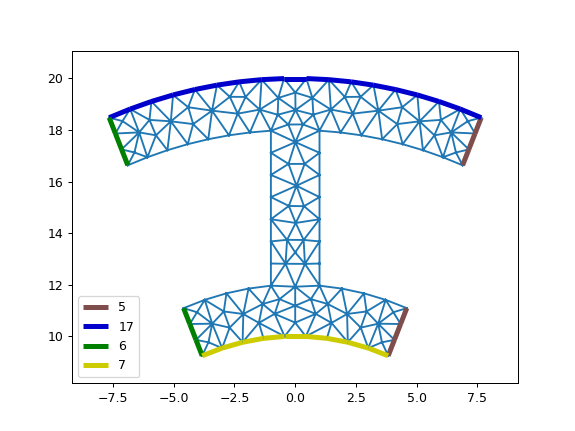

In [2]:
amfe.plot2Dmesh(m)

In [3]:
dirsub = m.get_submesh('phys_group', 7)

cyclic_left = m.get_submesh('phys_group', 5)
cyclic_right = m.get_submesh('phys_group', 6)
domain = m.set_domain('phys_group',9)
domain.split_in_partitions('phys_group')

from ipywidgets import interact
n = len(cyclic_right.global_node_list)-1
@interact(node_id_left=(0,n,1),node_id_right=(0,n,1)) 
def plot_nodes(node_id_left=0,node_id_right=0):
    fig, ax1 = plt.subplots(figsize=(5,5))
    amfe.plot_domain(domain,ax=ax1)
    amfe.plot_submesh(dirsub,ax=ax1,plot_1d=True)
    amfe.plot_submesh(cyclic_left,ax=ax1,plot_1d=True)
    ax1.plot(cyclic_left.get_node_coord(cyclic_left.global_node_list[node_id_left])[0],cyclic_left.get_node_coord(cyclic_left.global_node_list[node_id_left])[1],'o')
    ax1.plot(cyclic_right.get_node_coord(cyclic_right.global_node_list[node_id_right])[0],cyclic_right.get_node_coord(cyclic_right.global_node_list[node_id_right])[1],'o')

interactive(children=(IntSlider(value=0, description='node_id_left', max=7), IntSlider(value=0, description='n…

In [4]:
# creating a mechanical component
my_comp = amfe.MechanicalSystem()
my_comp.set_mesh_obj(m)
my_material = amfe.KirchhoffMaterial(E=210E9, nu=0.3, rho=7.86E3, plane_stress=True, thickness=1.0)
my_comp.set_domain(9,my_material)



Preallocating the stiffness matrix
Done preallocating stiffness matrix with 210 elements and 286 dofs.
Time taken for preallocation: 0.00 seconds.


In [5]:
n_modes = 10
cyclic_obj = Cyclic_Symmetry_Modal_Analysis(my_comp,
                               dirsub,
                               cyclic_left,
                               cyclic_right,
                               sector_angle=theta,
                               unit='rad',
                               tol_radius = 1e-3, 
                               node_diam_range = (0,3),
                               n_modes=n_modes)

comp_list = cyclic_obj.comp_ND_list
s = cyclic_obj.selector_operator


xy direction choosen for cyclic symmetry


C:\Users\ge72tih\AppData\Local\Continuum\anaconda3\envs\ndcsi\lib\site-packages\scipy\sparse\compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


<IPython.core.display.Javascript object>


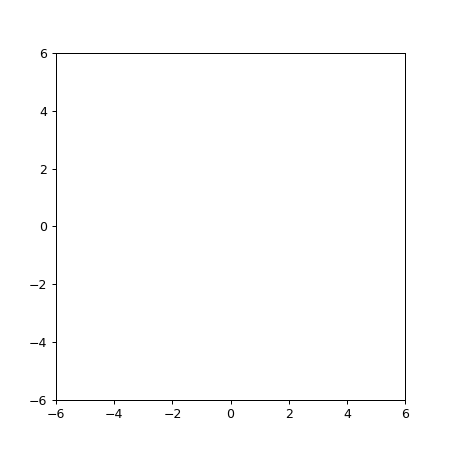

interactive(children=(FloatSlider(value=1.0, description='factor', max=1.0, min=-1.0), IntSlider(value=1, desc…

In [6]:
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
import mpl_toolkits.mplot3d as a3
from ipywidgets import interact

my_comp_list = []
    
fig4,ax3 = plt.subplots(1,figsize=(5,5))
bc = np.array([-6,6])

@interact(factor=(-1.0,1.0,0.1),mode_id=(0,n_modes,1),node_diam_ = (0,2,1))
def plot1(factor=1.0,mode_id=1,node_diam_=0):
    ax3.clear()
    my_comp.u_output = []
    
    my_comp_i = comp_list[node_diam_]
    amfe.plot_system_solution(my_comp_i, factor=1.0E2*factor, ax = ax3, u_id = mode_id)
    ax3.set_xlim(bc)
    ax3.set_ylim(bc)


#ax3.set_axis_off()

#factor_list = 0.2*np.sin(np.linspace(0,2*np.pi,20))
#ani = FuncAnimation(fig4,  plot1,factor_list , init_func=init,interval=10, blit=True)


In [7]:
cyclic_comp = Cyclic_Component(my_comp,
                      dirsub,
                      cyclic_left,
                      cyclic_right,
                      sector_angle=theta,
                      unit='rad',
                      tol_radius = 1e-3)

node_diam = 0
P_n_0 = cyclic_comp.build_complex_projection(0)
P_n_1 = cyclic_comp.build_complex_projection(1)
P_n_2 = cyclic_comp.build_complex_projection(2)

K_sector, M_sector = cyclic_comp.assemble_sector_operators()
s = cyclic_comp.s

xy direction choosen for cyclic symmetry


C:\Users\ge72tih\AppData\Local\Continuum\anaconda3\envs\ndcsi\lib\site-packages\scipy\sparse\compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [8]:
n_modes = 20
ndofs = cyclic_comp.ndofs
nc = cyclic_comp.nc

#K_inv = sparse.linalg.inv(K_sector)
#K_pinv = P_n.dot(K_inv).dot(P_n)
#P_n_inv = sparse.csc_matrix(np.linalg.pinv(P_n.toarray()))
res_dict = {}
P_n_list = [P_n_0,P_n_1,P_n_2]
for i in range(len(P_n_list)):
    
    P_n = P_n_list[i]

    Kp = P_n.conj().T.dot(K_sector.dot(P_n))
    scipy_K_inv = sparse.csc_matrix(np.linalg.pinv(Kp.toarray()))

    
    I = sparse.eye(ndofs)
    
    pre_obj1 = ProjPrecondLinearSys(K_sector,P_n, incomplete=True )
    pre_obj2 = ProjPrecondLinearSys(K_sector,P_n, incomplete=False )
    pre_obj3 = ProjPrecondLinearSys(K_sector,I, incomplete=True )
    pre_obj4 = ProjPrecondLinearSys(K_sector,I, incomplete=False )
    #pre_obj5 = ProjPrecondLinearSys(Kp,I, incomplete=False )
    
    #lu = sparse.linalg.splu(K_sector)
    #lui = sparse.linalg.spilu(K_sector)
    #lun = sparse.linalg.splu(Kp)

    precond0 = I
    precond1 = pre_obj1.getLinearOperator()
    precond2 = pre_obj2.getLinearOperator()
    precond3 = pre_obj3.getLinearOperator()
    precond4 = pre_obj4.getLinearOperator()
    #precond5 = pre_obj5.getLinearOperator()
    precond5 = scipy_K_inv

    list_precond = [precond0,
                   precond1,
                   precond2,
                   precond3,
                   precond4,
                   precond5]

    for j in range(len(list_precond)): #
        precond_j = list_precond[j]
        lo_obj = ProjLinearSys(K_sector,M_sector,P_n,precond_j)
        Dp_new = lo_obj.getLinearOperator()
        w2new, v2new = sparse.linalg.eigs(Dp_new, k=n_modes)
        new_id = np.argsort(w2new)[::-1]
        w2new = w2new[new_id]
        v2new = v2new[:,new_id]

        #u_vnew = assemble_cyclic_modes(s,v2new,node_id=node_diam,compute_left=False,dimension=2)
        u_vnew = assemble_cyclic_modes(s,v2new,node_id=i,compute_left=False,dimension=2)
        comp_i = copy.deepcopy(my_comp)
        comp_i.u_output = []
        comp_i.u_output = list(u_vnew.T)
        local_dict = {}
        local_dict['comp']= comp_i
        local_dict['linearOp'] = lo_obj
        local_dict['TotalLienarOpCall'] = lo_obj.num_iters
        local_dict['AvgLienarOpCall'] = lo_obj.num_iters/lo_obj.solver_counter
        local_dict['eigenvalues'] = w2new
        local_dict['SolverCalls'] = lo_obj.solver_counter
        res_dict[i,j] =local_dict


In [9]:
res_dict

{(0, 0): {'comp': <amfe.mechanical_system.MechanicalSystem at 0x1a2d3f93eb8>,
  'linearOp': <amfe.linalg.arnoldi.ProjLinearSys at 0x1a2d3f93c50>,
  'TotalLienarOpCall': 10430,
  'AvgLienarOpCall': 165.55555555555554,
  'eigenvalues': array([1.10078651e-04+4.29841220e-19j, 6.56895173e-06-2.68907497e-20j,
         2.84487090e-06-2.17271958e-21j, 1.71259053e-06+1.98451760e-20j,
         8.63468138e-07-1.49496045e-20j, 3.47443276e-07-4.93305711e-20j,
         3.07013872e-07+3.01802370e-20j, 2.37628875e-07-2.23971714e-20j,
         2.05649884e-07+3.62634277e-20j, 1.99583118e-07+7.13776378e-20j,
         1.60814161e-07+3.51076717e-21j, 1.26324479e-07+1.18024228e-20j,
         8.67718626e-08+4.99087169e-20j, 8.25453616e-08-2.08386915e-20j,
         6.87166945e-08-7.57527187e-20j, 5.93007761e-08-1.26809406e-19j,
         5.53122339e-08-7.03186268e-20j, 5.46283842e-08-5.61630793e-20j,
         5.09360889e-08+2.58225804e-19j, 5.04771904e-08-8.42505230e-20j]),
  'SolverCalls': 63},
 (0, 1): {'com

<IPython.core.display.Javascript object>


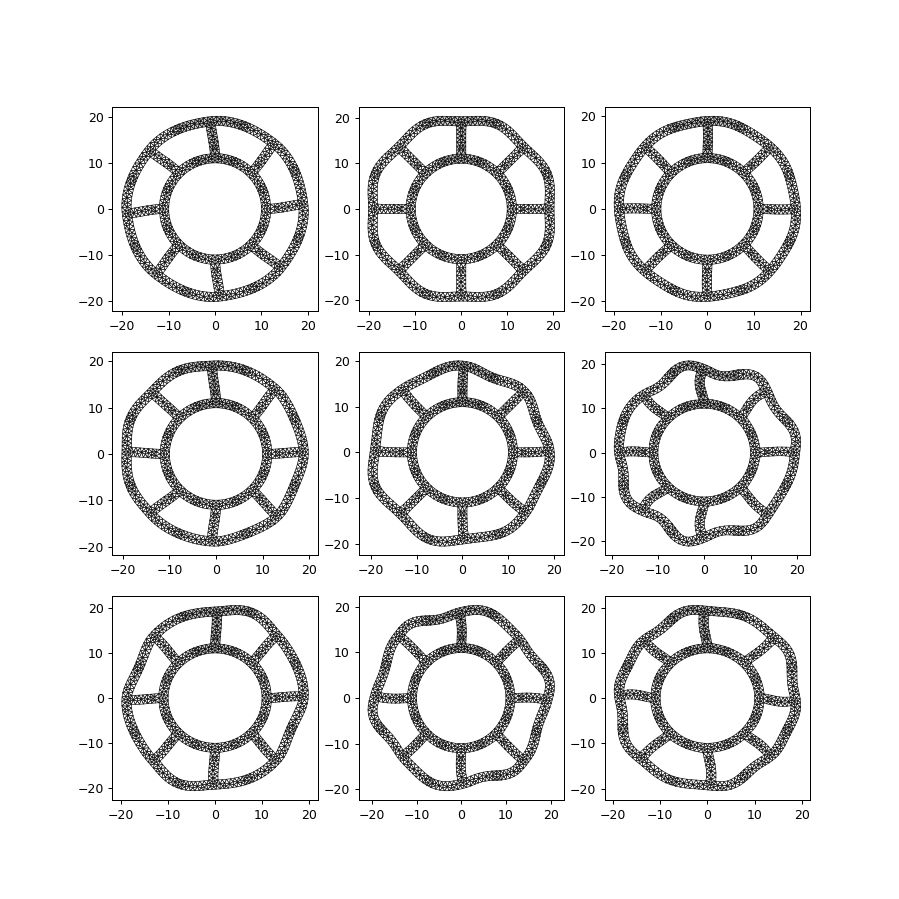

interactive(children=(FloatSlider(value=0.1, description='factor', max=1.0, min=-1.0, step=0.05), IntSlider(va…

In [10]:
def create_sector_list(my_comp,node_diam):
    sector_list = []
    for i in range(n_sector):
        sector_i = create_rotated_component(my_comp,s,sector_id=i, node_id=node_diam, theta=theta, unit='rad', dimension=2)
        sector_list.append(sector_i)
    return sector_list

def plot_sector_list(sector_list, factor, ax1, mode_id):
    ax1.clear()
    reference = True
    for sector_i in sector_list:
        if reference:
            amfe.plot_system_solution(sector_i, factor=100*factor, ax = ax1, u_id = mode_id, facecolor=0.8*np.array((1,1,1)))
            reference = False
        else:
            amfe.plot_system_solution(sector_i, factor=100*factor, ax = ax1, u_id = mode_id)

precond_id = 1        
comp2new_1 = res_dict[0,precond_id]['comp']
comp2new_2 = res_dict[1,precond_id]['comp']
comp2new_3 = res_dict[2,precond_id]['comp']
sector_list_1 = create_sector_list(comp2new_1,0)
sector_list_2 = create_sector_list(comp2new_2,1)
sector_list_3 = create_sector_list(comp2new_3,2)
#sector_list = []
#for i in range(n_sector):
#    sector_i = create_rotated_component(new_comp2new,s,sector_id=i, node_id=node_diam, theta=theta, unit='rad', dimension=2)
#    sector_list.append(sector_i)

fig1,((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3,3,figsize=(10,10))
bc = np.array([-6,6])

@interact(factor=(-1.0,1.0,0.05),mode_id=(0,n_modes,1))
def plot2(factor=0.1,mode_id=0):
    #ax1.clear()
    #for sector_i in sector_list:
    #    amfe.plot_system_solution(sector_i, factor=10*factor, ax = ax1, u_id = mode_id)
    plot_sector_list(sector_list_1, 1*factor, ax1, mode_id)
    plot_sector_list(sector_list_1, factor, ax2, mode_id+1)
    plot_sector_list(sector_list_1, factor, ax3, mode_id+2)
    plot_sector_list(sector_list_2, factor, ax4, mode_id)
    plot_sector_list(sector_list_2, factor, ax5, mode_id+1)
    plot_sector_list(sector_list_2, factor, ax6, mode_id+2)
    plot_sector_list(sector_list_3, factor, ax7, mode_id)
    plot_sector_list(sector_list_3, factor, ax8, mode_id+1)
    plot_sector_list(sector_list_3, factor, ax9, mode_id+2)


In [11]:
columns = ['ND0','ND1','ND2']
index = ['I','$P(incK)^{-1}P$','$PK^{-1}P$','inc(K)^-1','K^-1','(PK^P)^-1']


data = np.zeros((len(list_precond),len(P_n_list)),dtype=np.float)

for i in range(len(P_n_list)):
    for j in range(len(list_precond)):
        data[j,i] = res_dict[i,j]['AvgLienarOpCall']
        
df = pd.DataFrame(data, index=index, columns=columns)

df

,ND0,ND1,ND2
I,165.555556,163.301587,162.650794
$P(incK)^{-1}P$,42.253968,45.317460,46.111111
$PK^{-1}P$,18.952381,20.000000,19.968254
inc(K)^-1,42.142857,45.174603,45.984127
K^-1,18.952381,20.000000,19.984127
(PK^P)^-1,1.000000,1.000000,1.000000


In [12]:
print('Number of dofs is equal to %i ' %K_sector.shape[0])

Number of dofs is equal to 266 
